In [1]:
import numpy as np
from astropy.time import Time

def prepare_and_save_real_data_adjusted(
    data_path,
    save_file_path,
    keys=['X', 'NIR', 'IR', 'Sub-mm'],
    mask_eval_fraction=0.2
):
    """
    Prepares, standardizes, and masks a specified fraction of real observed data for evaluation.
    Saves all values in their standardized form.

    Args:
        data_path (str): Directory with raw data files.
        save_file_path (str): Base path to save output npz files.
        keys (list): Names of each channel.
        mask_eval_fraction (float): Fraction of observed data to mask per channel.
    """

    data_dict = {}
    eval_ground_truth = {}
    max_time = 0

    # Load raw data and align time axis
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 2] * 1e3
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd, flux = df[:, 2], df[:, 3]
        else:
            raise ValueError(f"Unknown key: {key}")

        time = Time(bmjd, format='mjd', scale='tcb').utc.to_datetime()
        start_time = min(time)
        minutes_since_start = np.array([(t - start_time).total_seconds() / 60 for t in time])

        data_dict[key] = {
            'time': minutes_since_start,
            'flux': flux
        }

        max_time = max(max_time, int(max(minutes_since_start)) + 1)

    # Build a standardized array with mask
    channels = len(keys)
    data = np.zeros((1, max_time, channels * 2 + 1))  # +1 for time channel

    for j, key in enumerate(keys):
        minutes = data_dict[key]['time'].astype(int)
        flux = data_dict[key]['flux']

        data[0, minutes, j] = flux
        data[0, minutes, channels + j] = 1  # Observed mask

    # Standardize each channel
    for j, key in enumerate(keys):
        channel_data = data[0, :, j]
        observed = data[0, :, channels + j] == 1
        if np.any(observed):
            mean = np.mean(channel_data[observed])
            std = np.std(channel_data[observed])
            std = std if std > 0 else 1.0  # Avoid division by zero
            data[0, :, j] = (channel_data - mean) / std

    # Mask a fraction of observed points for evaluation and store only them
    for j, key in enumerate(keys):
        observed_indices = np.where(data[0, :, channels + j] == 1)[0]
        num_to_mask = int(len(observed_indices) * mask_eval_fraction)
        if num_to_mask == 0:
            continue

        selected_indices = np.random.choice(observed_indices, num_to_mask, replace=False)

        # Store standardized times and flux values of masked points
        masked_times = selected_indices
        standardized_values = data[0, masked_times, j] # Already standardized

        eval_ground_truth[key] = {
            'times': masked_times,
            'values': standardized_values
        }

        # Mask them in the data
        data[0, masked_times, channels + j] = 0

    # Fill normalized time channel (e.g. for TripletFormer)
    data[0, :, -1] = np.linspace(0, 1, max_time)

    # Save full data
    np.savez(save_file_path, real_data=data)

    # Save MOGP version (without time channel)
    np.savez(save_file_path.replace('.npz', '_mogp.npz'), real_data=data[:, :, :-1])

    # Save only ground truth values and times for evaluation
    np.savez(save_file_path.replace('.npz', '_eval_ground_truth.npz'),
             **eval_ground_truth, allow_pickle=True)

    return data

In [2]:
import numpy as np

def compute_coverage(lower, upper, gt_values):
    """
    Computes the proportion of ground truth values that fall within the given interval.
    """
    return np.mean((gt_values >= lower) & (gt_values <= upper))

def get_coverage_data(keys=["X", 'NIR', "IR", "Sub-mm"],
                      gaussian_file='../GPyTorch/coverage_test.npz',
                      tripletformer_file='../Tripletformer/coverage_test.npz',
                      diffusion_file='../Diffusion/coverage_test.npz',
                      gt_file='coverage_test_data_eval_ground_truth.npz'):

    """
    Calculates the coverage for each model and wavelength and returns the data
    necessary for plotting.

    Returns:
        dict: A dictionary containing the coverage data for each model and wavelength.
              The keys of the dictionary are the model names ('MOGP', 'TripletFormer', 'CSPD'),
              and the values are lists of coverage values corresponding to the order of the 'keys' list.
    """

    # Load prediction files
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    # Load ground truth of masked points
    gt = np.load(gt_file, allow_pickle=True)

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    all_coverage = {model: [] for model in model_names}

    for key in keys:
        coverage_per_wavelength = {model: np.nan for model in model_names}

        all_test_x = [
            gaussian_data[f"{key}_test_x"],
            tripletformer_data[f"{key}_test_x"],
            diffusion_data[f"{key}_test_x"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        if key not in gt:
            print(f"[WARNING] Ground truth not found for wavelength: {key}")
            for model in model_names:
                all_coverage[model].append(np.nan)
            continue

        gt_item = gt[key].item()
        gt_times = gt_item['times']
        gt_values = gt_item['values']

        for i, model_name in enumerate(model_names):
            test_x = np.array(all_test_x[i]).squeeze()
            lower_bound = np.array(all_lowers[i])
            upper_bound = np.array(all_uppers[i])
            index_in_pred = {int(t): idx for idx, t in enumerate(test_x)}

            matched_pred_indices = []
            matched_gt_values = []

            for j, t in enumerate(gt_times):
                t = int(t)
                if t in index_in_pred:
                    matched_pred_indices.append(index_in_pred[t])
                    matched_gt_values.append(gt_values[j])

            matched_pred_indices = np.array(matched_pred_indices)
            matched_gt_values = np.array(matched_gt_values)

            if len(matched_pred_indices) > 0:
                lower = lower_bound[matched_pred_indices]
                upper = upper_bound[matched_pred_indices]
                coverage = compute_coverage(lower, upper, matched_gt_values)
                coverage_per_wavelength[model_name] = coverage
            else:
                print(f"[WARNING] No matching indices for {key} in model {model_name}")

        for model in model_names:
            all_coverage[model].append(coverage_per_wavelength[model])

    return all_coverage

def save_plot_data(filename, coverage_data, keys):
    """
    Saves the coverage data and wavelength keys to a .npz file.

    Args:
        filename (str): The name of the file to save the data to.
        coverage_data (dict): The dictionary containing coverage data per model.
        keys (list): The list of wavelength keys.
    """
    np.savez(filename, coverage_data=coverage_data, keys=keys)
    print(f"Plot data saved to {filename}")

In [ ]:
import numpy as np
import os
import subprocess

def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
    env = os.environ.copy()
    env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
    command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
    if args:
        command.extend(args)
    try:
        subprocess.run(command, check=True, env=env)
    except subprocess.CalledProcessError as e:
        print(f"Error running {notebook_path}: {e}")

if __name__ == "__main__":
    seed_values = np.arange(16, 25)  # Reduced for example
    data_path = '../../Data/'
    save_file_path = 'coverage_test_data.npz'
    keys = ["X", 'NIR', "IR", "Sub-mm"]
    mask_eval_fraction = 0.2
    original_cwd = os.getcwd()

    # Define the paths to the Python interpreters for each project
    gpytorch_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python')  # Adjust if your venv is named differently
    tripletformer_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python') # Adjust if your venv is named differently
    diffusion_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python')   # Adjust if your venv is named differently

    for seed in seed_values:
        np.random.seed(seed)
        prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

        # Run GPyTorch notebook with explicit interpreter and ignoring active venv
        gpytorch_dir = '../GPyTorch'
        os.chdir(gpytorch_dir)
        print(f"Running GPyTorch notebook in: {os.getcwd()} using interpreter: {gpytorch_python}")
        run_notebook_in_pipenv('coverage_test.ipynb', gpytorch_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
        os.chdir(original_cwd)

        # Run Tripletformer notebook with explicit interpreter and ignoring active venv
        tripletformer_dir = '../Tripletformer'
        os.chdir(tripletformer_dir)
        print(f"Running Tripletformer notebook in: {os.getcwd()} using interpreter: {tripletformer_python}")
        run_notebook_in_pipenv('coverage_test.ipynb', tripletformer_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
        os.chdir(original_cwd)

        # Run Diffusion notebook with explicit interpreter and ignoring active venv
        diffusion_dir = '../Diffusion'
        os.chdir(diffusion_dir)
        print(f"Running Diffusion notebook in: {os.getcwd()} using interpreter: {diffusion_python}")
        run_notebook_in_pipenv('coverage_test.ipynb', diffusion_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
        os.chdir(original_cwd)

        # Collect data (adjust paths as needed)
        gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')
        gaussian_output = os.path.join(gpytorch_dir, 'coverage_test.npz')
        triplet_output = os.path.join(tripletformer_dir, 'coverage_test.npz')
        diffusion_output = os.path.join(diffusion_dir, 'coverage_test.npz')

        plot_data = get_coverage_data(keys, gaussian_output, triplet_output, diffusion_output, gt_file)
        save_plot_data(os.path.join(original_cwd, f'coverage_plot_data_{seed}.npz'), plot_data, keys)

    print(f"Final working directory: {os.getcwd()}")

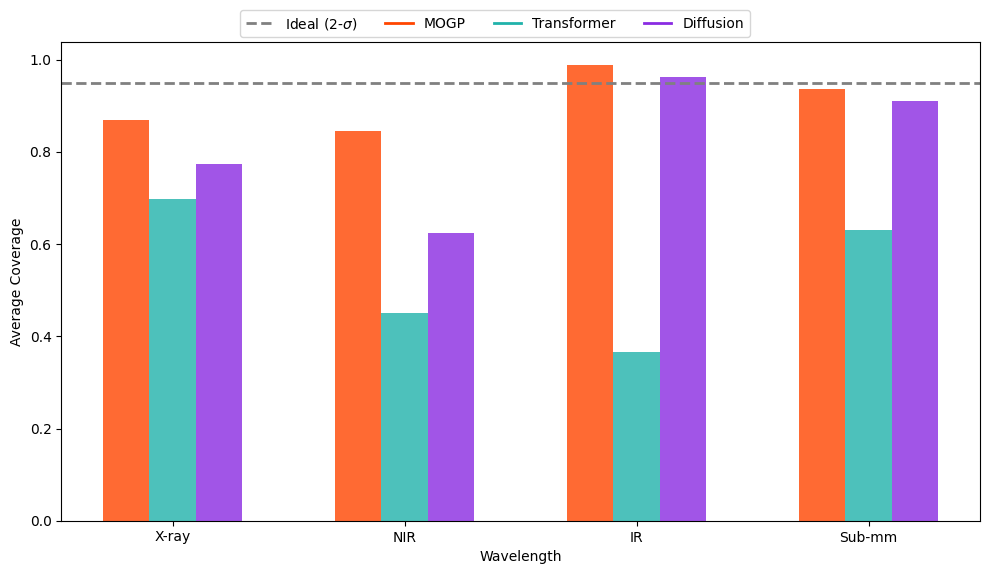

In [49]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Assuming the main script has been run and the individual seed files exist

all_seeds_coverage = {}
loaded_keys = None

# Load data from all seed files
for filename in glob.glob('coverage_plot_data_*.npz'):
    loaded_data = np.load(filename, allow_pickle=True)
    coverage_data = loaded_data['coverage_data'].item()
    keys = loaded_data['keys']
    seed_number = int(filename.split('_')[-1].split('.')[0])  # Extract seed number

    if loaded_keys is None:
        loaded_keys = keys

    for model, coverage_values in coverage_data.items():
        if model not in all_seeds_coverage:
            all_seeds_coverage[model] = {key: [] for key in keys}
        for i, key in enumerate(keys):
            if len(coverage_values) > i:
                all_seeds_coverage[model][key].append(coverage_values[i])

# Calculate the average coverage
average_coverage = {}
for model, wavelength_data in all_seeds_coverage.items():
    average_coverage[model] = {
        key: np.nanmean(values) if values else np.nan
        for key, values in wavelength_data.items()
    }

# Plot the average coverage
model_names = list(average_coverage.keys())
num_wavelengths = len(loaded_keys)
bar_width = 0.2
x = np.arange(num_wavelengths)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#FF4500', '#20B2AA', '#8A2BE2']
labels = ['X-ray', 'NIR', 'IR', 'Sub-mm']

for i, model_name in enumerate(model_names):
    avg_coverage_values = [average_coverage[model_name][key] for key in loaded_keys]
    positions = x + (i * bar_width - bar_width)
    ax.bar(positions, avg_coverage_values, bar_width, color=colors[i], alpha=0.8)

legend_handles = [Line2D([0], [0], color='grey', linestyle='--', label=r'Ideal (2-$\sigma$)', linewidth=2),
                 Line2D([0], [0], color='#FF4500', label='MOGP', linewidth=2),
                 Line2D([0], [0], color='#20B2AA', label='Transformer', linewidth=2),
                 Line2D([0], [0], color='#8A2BE2', label='Diffusion', linewidth=2)]
    
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=5)

ax.axhline(0.95, color='grey', linestyle='--', linewidth=2)
ax.set_ylabel("Average Coverage")
ax.set_xlabel("Wavelength")
ax.set_xticks(x)
ax.set_xticklabels(labels=labels)
# ax.grid(axis='y', alpha=0.7)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
# To load and plot later:
import numpy as np 

loaded_data = np.load('coverage_plot_data_17.npz', allow_pickle=True)
loaded_coverage_data = loaded_data['coverage_data'].item()
loaded_keys = loaded_data['keys']

import matplotlib.pyplot as plt

model_names = list(loaded_coverage_data.keys())
num_wavelengths = len(loaded_keys)
bar_width = 0.2
x = np.arange(num_wavelengths)

fig, ax = plt.subplots(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    positions = x + (i * bar_width - bar_width)
    ax.bar(positions, loaded_coverage_data[model_name], bar_width, label=model_name)

ax.axhline(0.95, color='grey', linestyle='--', label="Ideal (95%)")
ax.set_ylabel("Coverage")
ax.set_xlabel("Wavelength")
ax.set_title("Coverage of 95% Confidence Intervals on Masked Real Data")
ax.set_xticks(x)
ax.set_xticklabels(loaded_keys)
ax.legend()
ax.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.savefig('tmp.png')
plt.show()